# Load Dependencies

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModel,
    Trainer,
    TrainingArguments,
)
import warnings
warnings.filterwarnings('ignore')

# DATA LOADING

In [ ]:
def load_data(data_path='/content/'):
    """Load train and dev datasets"""
    print("\n" + "="*80)
    print(" LOADING DATASETS")
    print("="*80)

    with open(f'{data_path}train.json', 'r') as f:
        train_data = json.load(f)
    print(f" Loaded TRAIN dataset: {len(train_data)} stories")

    with open(f'{data_path}dev.json', 'r') as f:
        dev_data = json.load(f)
    print(f" Loaded DEV dataset: {len(dev_data)} stories")

    return train_data, dev_data

def prepare_dataframe(data, prefix=''):
    """Convert JSON to DataFrame"""
    stories_list = []
    for story_id, content in data.items():
        story_content = content.copy()
        story_content['story_id'] = f"{prefix}_{story_id}" if prefix else story_id
        stories_list.append(story_content)
    return pd.DataFrame(stories_list)

def create_full_story(row):
    """Combine precontext, sentence, and ending"""
    precontext = row.get('precontext', '').strip()
    sentence = row.get('sentence', '').strip()
    ending = row.get('ending', '').strip()
    return f"{precontext} {sentence} {ending}" if ending else f"{precontext} {sentence}"

def add_features(df):
    """Add engineered features"""
    df['full_story'] = df.apply(create_full_story, axis=1)
    df['has_ending'] = df['ending'].apply(lambda x: 1 if x and x.strip() else 0)
    return df

# Load data
train_data, dev_data = load_data()
train_df = prepare_dataframe(train_data, prefix='train')
dev_df = prepare_dataframe(dev_data, prefix='dev')
train_df = add_features(train_df)
dev_df = add_features(dev_df)

In [ ]:
print(f"\n{'Dataset':<15} {'Stories':<10} {'Annotations':<15} {'Unique Homonyms':<20}")
print("-" * 80)

train_annotations = sum(len(content['choices']) for content in train_data.values())
train_homonyms = len(train_df['homonym'].unique())
print(f"{'TRAIN':<15} {len(train_df):<10} {train_annotations:<15} {train_homonyms:<20}")

In [ ]:
print(f"\n{'Dataset':<15} {'Stories':<10} {'Annotations':<15} {'Unique Homonyms':<20}")
print("-" * 80)

train_annotations = sum(len(content['choices']) for content in train_data.values())
train_homonyms = len(train_df['homonym'].unique())
print(f"{'TRAIN':<15} {len(train_df):<10} {train_annotations:<15} {train_homonyms:<20}")

In [ ]:
dev_annotations = sum(len(content['choices']) for content in dev_data.values())
dev_homonyms = len(dev_df['homonym'].unique())
print(f"{'DEV':<15} {len(dev_df):<10} {dev_annotations:<15} {dev_homonyms:<20}")

In [ ]:
print(f"\n Dataset Split:")
print(f"   Training: {len(train_df)/total_stories*100:.1f}%")
print(f"   Development: {len(dev_df)/total_stories*100:.1f}%")

In [ ]:
print(f"\n Ratings per story: 5 human annotations")
print(f"   Rating scale: 1 (not plausible) to 5 (completely plausible)")

# IDENTIFY CHALLENGING HOMONYMS

In [ ]:
print(" IDENTIFYING CHALLENGING HOMONYMS")
print("="*80)

# Calculate difficulty (average stdev) per homonym
homonym_difficulty = train_df.groupby('homonym').agg({
    'stdev': 'mean',
    'story_id': 'count'
}).rename(columns={'story_id': 'count'})
homonym_difficulty = homonym_difficulty[homonym_difficulty['count'] >= 3]
homonym_difficulty = homonym_difficulty.sort_values('stdev', ascending=False)

CHALLENGING_HOMONYMS = list(homonym_difficulty.head(15).index)

print(f"\nTop 15 Most Challenging Homonyms (by average stdev in TRAIN set):")
print(f"{'Homonym':<20} {'Train Count':<15} {'Avg StdDev':<15}")
print("-" * 50)
for homonym in CHALLENGING_HOMONYMS:
    train_count = len(train_df[train_df['homonym'] == homonym])
    dev_count = len(dev_df[dev_df['homonym'] == homonym])
    avg_stdev = homonym_difficulty.loc[homonym, 'stdev']
    print(f"{homonym:<20} {train_count:<15} {avg_stdev:<15.3f}")

# PROMPT ENGINEERING

In [ ]:
def create_prompt(row, train_df=None, include_example=False):
    """Create compact prompt for the model"""
    homonym = row['homonym']
    meaning = row['judged_meaning'][:100]
    story = row['full_story']

    # Truncate story to fit in token limit
    story_words = story.split()
    if len(story_words) > 80:
        story = ' '.join(story_words[:80]) + '...'

    prompt = f"Word: {homonym}\nMeaning: {meaning}\nStory: {story}\nRating (1-5):"

    # Add example for challenging homonyms
    if include_example and homonym in CHALLENGING_HOMONYMS and train_df is not None:
        examples = train_df[train_df['homonym'] == homonym]
        if len(examples) > 0:
            ex = examples.iloc[0]
            ex_story = ' '.join(ex['full_story'].split()[:20])
            prompt = f"Example: {ex_story}... Rating: {int(ex['average'])}\n\n{prompt}"

    return prompt


# MODEL ARCHITECTURE

In [ ]:
class ImprovedModel(nn.Module):
    """
    Homonym-Aware Model with Multi-Task Learning
    - Main task: Rating prediction
    - Auxiliary task: Uncertainty prediction
    """

    def __init__(self, model_name='roberta-base', n_homonyms=300, dropout=0.2):
        super().__init__()

        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size

        self.homonym_embedding = nn.Embedding(n_homonyms, 32)
        self.attention = nn.Linear(hidden_size, 1)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_size + 32)

        self.regressor = nn.Sequential(
            nn.Linear(hidden_size + 32, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )

        self.uncertainty_head = nn.Sequential(
            nn.Linear(hidden_size + 32, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, input_ids, attention_mask, homonym_ids, labels=None, stdevs=None):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

        # Attention pooling
        attention_weights = torch.softmax(
            self.attention(outputs.last_hidden_state).squeeze(-1) +
            (1 - attention_mask.float()) * -10000,
            dim=1
        )
        pooled = torch.sum(outputs.last_hidden_state * attention_weights.unsqueeze(-1), dim=1)

        homonym_emb = self.homonym_embedding(homonym_ids)
        combined = torch.cat([pooled, homonym_emb], dim=1)
        combined = self.layer_norm(combined)
        combined = self.dropout(combined)

        rating_logits = self.regressor(combined)
        uncertainty_logits = self.uncertainty_head(combined)

        loss = None
        if labels is not None:
            rating_loss = nn.MSELoss()(rating_logits.squeeze(), labels)
            if stdevs is not None:
                uncertainty_loss = nn.MSELoss()(uncertainty_logits.squeeze(), stdevs)
                loss = rating_loss + 0.3 * uncertainty_loss
            else:
                loss = rating_loss

        return {'loss': loss, 'logits': rating_logits, 'uncertainty': uncertainty_logits}

# DATASET CLASS

In [ ]:
class CompactDataset(Dataset):
    """PyTorch Dataset with proper token management"""

    def __init__(self, dataframe, tokenizer, train_df=None, max_length=256,
                 include_example=False, dataset_name=''):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.train_df = train_df
        self.max_length = max_length
        self.include_example = include_example
        self.dataset_name = dataset_name

        all_homonyms = sorted(set(dataframe['homonym'].unique()))
        self.homonym_to_id = {h: i for i, h in enumerate(all_homonyms)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = create_prompt(row, self.train_df, self.include_example)

        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )

        homonym_id = self.homonym_to_id.get(row['homonym'], 0)
        rating = (row['average'] - 1) / 4.0
        stdev = row['stdev'] / 2.0

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'homonym_ids': torch.tensor(homonym_id, dtype=torch.long),
            'labels': torch.tensor(rating, dtype=torch.float),
            'stdevs': torch.tensor(stdev, dtype=torch.float)
        }


# CUSTOM TRAINER

In [ ]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        stdevs = inputs.pop("stdevs")
        outputs = model(**inputs, labels=labels, stdevs=stdevs)
        loss = outputs['loss']
        return (loss, outputs) if return_outputs else loss


# TRAINING FUNCTION

In [ ]:
def train_model(model_name='bert-base-uncased', epochs=5, batch_size=16, lr=2e-5):
    print("\n" + "="*80)
    print("TRAINING CONFIGURATION")
    print("="*80)
    print(f"\n Model: {model_name}")
    print(f" Epochs: {epochs}")
    print(f" Batch Size: {batch_size}")
    print(f" Learning Rate: {lr}")
    print(f" Max Token Length: 256")

    print(f"\n Data Usage:")
    print(f"   TRAINING on:   {len(train_df)} stories (TRAIN dataset)")
    print(f"   VALIDATING on: {len(dev_df)} stories (DEV dataset)")
    print(f"   Total batches per epoch: {len(train_df) // batch_size}")
    print(f"   Total training steps: {(len(train_df) // batch_size) * epochs}")

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Create datasets with clear names
    print(f"\n Creating PyTorch Datasets...")
    train_dataset = CompactDataset(
        train_df, tokenizer, train_df, max_length=256,
        include_example=False, dataset_name='TRAIN'
    )
    print(f"    TRAIN Dataset: {len(train_dataset)} samples")

    eval_dataset = CompactDataset(
        dev_df, tokenizer, train_df, max_length=256,
        include_example=False, dataset_name='DEV'
    )
    print(f"    DEV Dataset: {len(eval_dataset)} samples")

    n_homonyms = len(set(train_df['homonym'].unique()) | set(dev_df['homonym'].unique()))
    print(f"\n Vocabulary: {n_homonyms} unique homonyms")

    model = ImprovedModel(model_name=model_name, n_homonyms=n_homonyms, dropout=0.2)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    print(f"💻 Device: {device}")

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=lr,
        warmup_ratio=0.1,
        weight_decay=0.01,
        logging_steps=100,
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='eval_loss',
        report_to='none',
        fp16=torch.cuda.is_available(),
    )

    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset
    )

    print("\n" + "="*80)
    print(" TRAINING IN PROGRESS...")
    print("="*80)
    print(f"Training on {len(train_df)} TRAIN samples")
    print(f"Validating on {len(dev_df)} DEV samples after each epoch\n")

    trainer.train()

    return trainer, tokenizer, model, train_dataset.homonym_to_id

# PREDICTION FUNCTION

In [ ]:
def predict(model, tokenizer, test_df, train_df, homonym_to_id,
           batch_size=16, dataset_name='TEST'):
    """Generate predictions"""
    print(f"\n🔮 Generating predictions on {dataset_name} dataset ({len(test_df)} samples)...")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    test_dataset = CompactDataset(
        test_df, tokenizer, train_df, max_length=256,
        include_example=False, dataset_name=dataset_name
    )
    test_dataset.homonym_to_id = homonym_to_id

    dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    predictions = []
    uncertainties = []

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if (i + 1) % 10 == 0:
                print(f"   Processed {(i+1)*batch_size}/{len(test_df)} samples...")

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            homonym_ids = batch['homonym_ids'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                          homonym_ids=homonym_ids)

            preds = (outputs['logits'].squeeze().cpu().numpy() * 4) + 1
            uncerts = outputs['uncertainty'].squeeze().cpu().numpy() * 2

            predictions.extend(preds if isinstance(preds, np.ndarray) else [preds])
            uncertainties.extend(uncerts if isinstance(uncerts, np.ndarray) else [uncerts])

    print(f"   ✅ Generated {len(predictions)} predictions")
    return np.array(predictions), np.array(uncertainties)


#EVALUATION FUNCTION

In [ ]:
def evaluate(predictions, targets, stdevs, dataset_name='DEV'):
    """Evaluate predictions"""
    predictions = np.clip(predictions, 1, 5)

    spearman_corr, _ = spearmanr(predictions, targets)
    acc = sum(abs(p - t) <= max(s, 1.0)
              for p, t, s in zip(predictions, targets, stdevs)) / len(predictions)
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    mae = mean_absolute_error(targets, predictions)

    print("\n" + "="*80)
    print(f" EVALUATION RESULTS ON {dataset_name} DATASET")
    print("="*80)
    print(f"\n{'Metric':<30} {'Score':<15} {'Target':<15} {'Status':<10}")
    print("-" * 70)
    print(f"{'Spearman Correlation':<30} {spearman_corr:<15.4f} {'>0.45':<15} {'✅' if spearman_corr > 0.45 else '⚠️'}")
    print(f"{'Accuracy Within StdDev':<30} {acc:<15.4f} {'>0.70':<15} {'✅' if acc > 0.70 else '⚠️'}")
    print(f"{'RMSE':<30} {rmse:<15.4f} {'<1.10':<15} {'✅' if rmse < 1.10 else '⚠️'}")
    print(f"{'MAE':<30} {mae:<15.4f} {'<0.90':<15} {'✅' if mae < 0.90 else '⚠️'}")

    return {
        'spearman': spearman_corr,
        'accuracy_within_std': acc,
        'rmse': rmse,
        'mae': mae
    }


# MAIN EXECUTION

In [ ]:
print("\n" + "="*80)
print("SEMEVAL 2026 TASK 5: WORD SENSE PLAUSIBILITY RATING")
print("="*80)

# Train
trainer, tokenizer, model, homonym_to_id = train_model(
    model_name='roberta-base',
    epochs=5,
    batch_size=16,
    lr=2e-5
)

# Predict on DEV set
predictions, uncertainties = predict(
    model, tokenizer, dev_df, train_df, homonym_to_id,
    dataset_name='DEV'
)

# Evaluate
results = evaluate(
    predictions, dev_df['average'].values, dev_df['stdev'].values,
    dataset_name='DEV'
)

# DETAILED ANALYSIS

In [ ]:

print("🔍 DETAILED ANALYSIS ON DEV DATASET")
print("="*80)

dev_df['prediction'] = predictions
dev_df['error'] = np.abs(predictions - dev_df['average'].values)

# Performance on challenging homonyms
print(f"\n Performance on Top 10 Challenging Homonyms (from TRAIN analysis):")
print(f"{'Homonym':<20} {'Dev Count':<12} {'Avg Error':<12} {'Status':<10}")
print("-" * 54)

for homonym in CHALLENGING_HOMONYMS[:10]:
    data = dev_df[dev_df['homonym'] == homonym]
    if len(data) > 0:
        avg_error = data['error'].mean()
        status = '✅' if avg_error < 1.0 else '⚠️' if avg_error < 1.5 else '🔴'
        print(f"{homonym:<20} {len(data):<12} {avg_error:<12.3f} {status:<10}")

# Error by dataset features
print(f"\n Error Analysis by Story Features (DEV dataset):")
print(f"\nWith Ending vs Without:")
ending_analysis = dev_df.groupby('has_ending')['error'].agg(['mean', 'count'])
ending_analysis.index = ['No Ending', 'Has Ending']
print(ending_analysis)

# VISUALIZATION


 LOADING DATASETS
 Loaded TRAIN dataset: 2280 stories
 Loaded DEV dataset: 588 stories

 DATASET STATISTICS

Dataset         Stories    Annotations     Unique Homonyms     
--------------------------------------------------------------------------------
TRAIN           2280       11434           220                 
DEV             588        2952            55                  
--------------------------------------------------------------------------------
TOTAL           2868       14386           275                 

 Dataset Split:
   Training: 79.5%
   Development: 20.5%

 Ratings per story: 5 human annotations
   Rating scale: 1 (not plausible) to 5 (completely plausible)

 IDENTIFYING CHALLENGING HOMONYMS

Top 15 Most Challenging Homonyms (by average stdev in TRAIN set):
Homonym              Train Count     Avg StdDev     
--------------------------------------------------
draft                6               1.534          
quarter              6               1.487         

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


 Creating PyTorch Datasets...
    TRAIN Dataset: 2280 samples
    DEV Dataset: 588 samples

 Vocabulary: 275 unique homonyms


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

💻 Device: cuda

 TRAINING IN PROGRESS...
Training on 2280 TRAIN samples
Validating on 588 DEV samples after each epoch



Epoch,Training Loss,Validation Loss
1,0.168700,0.116278
2,0.119700,0.115909
3,0.105000,0.112398
4,0.094700,0.115960
5,0.076600,0.121130



🔮 Generating predictions on DEV dataset (588 samples)...
   Processed 160/588 samples...
   Processed 320/588 samples...
   Processed 480/588 samples...
   ✅ Generated 588 predictions

 EVALUATION RESULTS ON DEV DATASET

Metric                         Score           Target          Status    
----------------------------------------------------------------------
Spearman Correlation           0.1718          >0.45           ⚠️
Accuracy Within StdDev         0.5816          >0.70           ⚠️
RMSE                           1.1925          <1.10           ⚠️
MAE                            1.0119          <0.90           ⚠️

🔍 DETAILED ANALYSIS ON DEV DATASET

 Performance on Top 10 Challenging Homonyms (from TRAIN analysis):
Homonym              Dev Count    Avg Error    Status    
------------------------------------------------------

 Error Analysis by Story Features (DEV dataset):

With Ending vs Without:
                mean  count
No Ending   0.922519    196
Has Ending  1.056582 

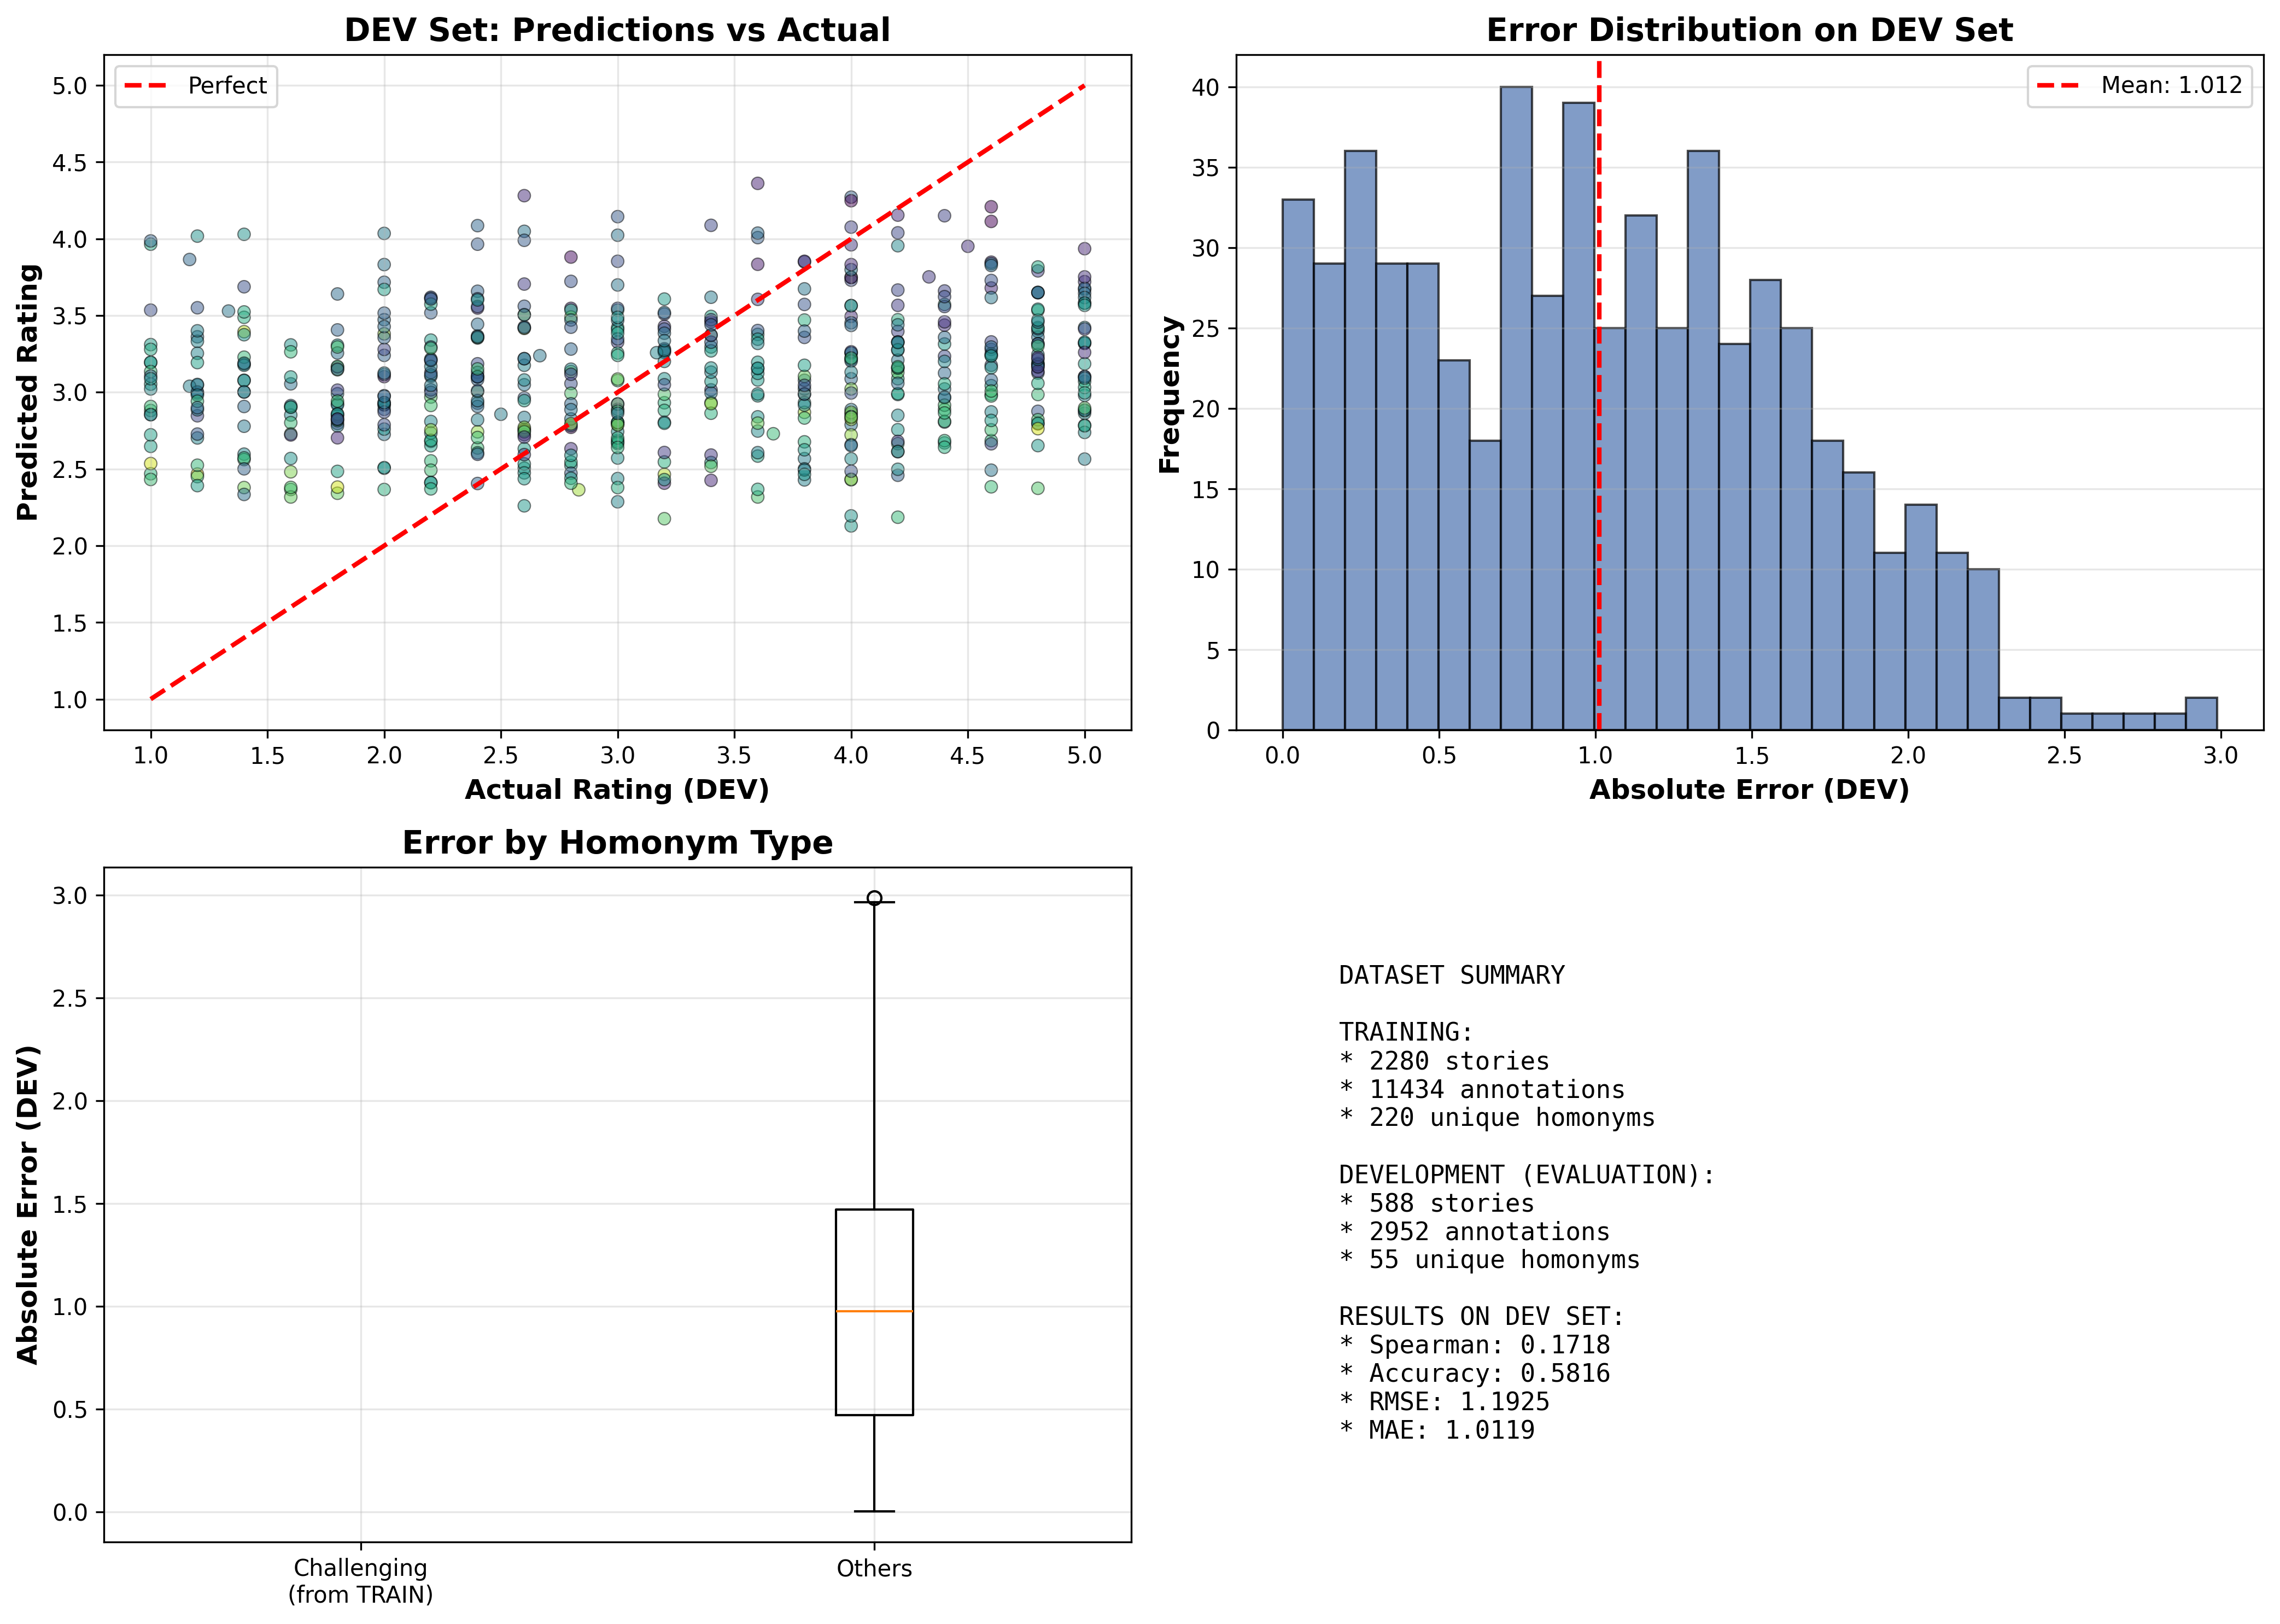


TRAINING AND EVALUATION COMPLETE!

 Results saved to: model_results_with_dataset_info.png
 Model checkpoints saved to: ./results/

 Final Performance on DEV dataset:
   Spearman Correlation: 0.1718
   Accuracy Within StdDev: 0.5816


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=300)

# 1. Predictions vs Actual
axes[0, 0].scatter(dev_df['average'], predictions, alpha=0.5, c=uncertainties,
                   cmap='viridis', s=30, edgecolors='black', linewidth=0.5)
axes[0, 0].plot([1, 5], [1, 5], 'r--', linewidth=2, label='Perfect')
axes[0, 0].set_xlabel('Actual Rating (DEV)', fontsize=12, weight='bold')
axes[0, 0].set_ylabel('Predicted Rating', fontsize=12, weight='bold')
axes[0, 0].set_title('DEV Set: Predictions vs Actual', fontsize=14, weight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Error distribution
axes[0, 1].hist(dev_df['error'], bins=30, color='#4C72B0',
                edgecolor='black', alpha=0.7)
axes[0, 1].axvline(dev_df['error'].mean(), color='red', linestyle='--',
                   linewidth=2, label=f'Mean: {dev_df["error"].mean():.3f}')
axes[0, 1].set_xlabel('Absolute Error (DEV)', fontsize=12, weight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=12, weight='bold')
axes[0, 1].set_title('Error Distribution on DEV Set', fontsize=14, weight='bold')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Challenging vs Other homonyms
challenging_errors = dev_df[dev_df['homonym'].isin(CHALLENGING_HOMONYMS)]['error']
other_errors = dev_df[~dev_df['homonym'].isin(CHALLENGING_HOMONYMS)]['error']

axes[1, 0].boxplot([challenging_errors, other_errors],
                   labels=['Challenging\n(from TRAIN)', 'Others'])
axes[1, 0].set_ylabel('Absolute Error (DEV)', fontsize=12, weight='bold')
axes[1, 0].set_title('Error by Homonym Type', fontsize=14, weight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Dataset summary
axes[1, 1].axis('off')
summary_text = f"""
DATASET SUMMARY

TRAINING:
* {len(train_df)} stories
* {train_annotations} annotations
* {train_homonyms} unique homonyms

DEVELOPMENT (EVALUATION):
* {len(dev_df)} stories
* {dev_annotations} annotations
* {dev_homonyms} unique homonyms

RESULTS ON DEV SET:
* Spearman: {results['spearman']:.4f}
* Accuracy: {results['accuracy_within_std']:.4f}
* RMSE: {results['rmse']:.4f}
* MAE: {results['mae']:.4f}
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
               verticalalignment='center')

plt.tight_layout()
plt.savefig('model_results_with_dataset_info.png')
plt.show()

print("\n" + "="*80)
print("TRAINING AND EVALUATION COMPLETE!")
print("="*80)
print(f"\n Results saved to: model_results_with_dataset_info.png")
print(f" Model checkpoints saved to: ./results/")
print(f"\n Final Performance on DEV dataset:")
print(f"   Spearman Correlation: {results['spearman']:.4f}")
print(f"   Accuracy Within StdDev: {results['accuracy_within_std']:.4f}")